<a href="https://colab.research.google.com/github/adbertin/salaryConvergence/blob/main/Part1_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#Import

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.backends.backend_pdf import PdfPages

## Estimation and analysis of hourly wages across countries over time

In [12]:
# --- 1. LOAD CSV FILES ---
df_emp = pd.read_csv('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/employment_ratio.csv')
df_gdp = pd.read_csv('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/gdp_per_capita_ppp.csv')
df_labsh = pd.read_csv('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/pwt_labor_share_extended.csv')
df_hours = pd.read_csv('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/Hours_extrapolated_1990_2023_selected.csv')


# --- 2. NORMALIZE COLUMN NAMES ---
df_emp.columns = df_emp.columns.str.strip().str.lower()
df_gdp.columns = df_gdp.columns.str.strip().str.lower()
df_labsh.columns = df_labsh.columns.str.strip().str.lower()
df_hours.columns = df_hours.columns.str.strip().str.lower()

print("EMP columns:", df_emp.columns.tolist())
print("GDP columns:", df_gdp.columns.tolist())
print("LABSH columns:", df_labsh.columns.tolist())
print("HOURS columns:", df_hours.columns.tolist())  # Check how the working hours file is structured

# --- 3. MELT (UNPIVOT) THE WIDE DATAFRAMES ---
# For Employment ratio & GDP, we assume: "country code", "country", "series name", plus year columns.
df_emp_melt = df_emp.melt(
    id_vars=["country code", "country", "series name"],
    var_name="year",
    value_name="empratio"
)

df_gdp_melt = df_gdp.melt(
    id_vars=["country code", "country", "series name"],
    var_name="year",
    value_name="gdpcap"
)

# For Labor share (PWT), we assume: "iso code", "country", "variable code", "variable name"
df_labsh_melt = df_labsh.melt(
    id_vars=["iso code", "country", "variable code", "variable name"],
    var_name="year",
    value_name="laborshare"
)

# For Penn working hours, from your screenshot:
# "Country" in first column, then columns for each year (1990, 1991, ...)
df_hours_melt = df_hours.melt(
    id_vars=["country"],      # keep "country" fixed
    var_name="year",          # melted columns become "year"
    value_name="whours"       # melted values become "whours"
)

# --- 4. RENAME / ALIGN COLUMNS FOR CONSISTENCY ---
df_emp_melt.rename(columns={"country code": "wb_countrycode"}, inplace=True)
df_gdp_melt.rename(columns={"country code": "wb_countrycode"}, inplace=True)
df_labsh_melt.rename(columns={"iso code": "iso_code"}, inplace=True)
# For hours, if you have a separate ISO code or if you rely on "country" only,
# you might later need to do name matching or rename "country" to "iso_code".
# For simplicity, let's assume we match on "country" + "year".

# --- 5. CREATE A COMMON MERGE KEY ---
df_emp_melt["iso_code"] = df_emp_melt["wb_countrycode"]
df_gdp_melt["iso_code"] = df_gdp_melt["wb_countrycode"]

# Convert "year" columns to numeric
for df_ in [df_emp_melt, df_gdp_melt, df_labsh_melt, df_hours_melt]:
    df_["year"] = pd.to_numeric(df_["year"], errors="coerce")

# --- 6. MERGE EMP + GDP + LABOR SHARE ---
df_merged_1 = pd.merge(
    df_emp_melt[["iso_code", "country", "year", "empratio"]],
    df_gdp_melt[["iso_code", "country", "year", "gdpcap"]],
    on=["iso_code", "year"],
    how="outer"
)

df_merged = pd.merge(
    df_merged_1,
    df_labsh_melt[["iso_code", "year", "laborshare"]],
    on=["iso_code", "year"],
    how="outer"
)

# --- 7. CONVERT TO NUMERIC (if not already) ---
df_merged["empratio"]   = pd.to_numeric(df_merged["empratio"], errors="coerce")
df_merged["gdpcap"]     = pd.to_numeric(df_merged["gdpcap"], errors="coerce")
df_merged["laborshare"] = pd.to_numeric(df_merged["laborshare"], errors="coerce")

# >>>>> INSERTED CODE: Unify country columns <<<<<
# Rename one of the duplicate country columns to "country" and drop the other
df_merged.rename(columns={"country_x": "country"}, inplace=True)
if "country_y" in df_merged.columns:
    df_merged.drop(columns=["country_y"], inplace=True)
# -----------------------------------------------------

# --- 8. MERGE WORKING HOURS ---
# Merge on "country" + "year"
df_final = pd.merge(
    df_merged,
    df_hours_melt[["country", "year", "whours"]],
    on=["country", "year"],
    how="inner"  # or "outer" if you want to keep all rows and then filter missing
)

# --- 9. FILTER OUT ROWS THAT LACK ANY COMPONENT (we only want complete data) ---
df_final = df_final.dropna(subset=["empratio", "gdpcap", "laborshare", "whours"])

# --- 10. COMPUTE ESTIMATED HOURLY WAGE ---
df_final["empratio_fraction"] = df_final["empratio"] / 100.0

def compute_est_hourly_wage(row):
    print(
        f"{row['country']}, {row['year']}, "
        f"empratio={row['empratio']}, gdpcap={row['gdpcap']}, "
        f"laborshare={row['laborshare']}, whours={row['whours']}"
    )
    annual_wage = (row["gdpcap"] * row["laborshare"]) / (row["empratio"] / 100.0)
    hourly_wage = annual_wage / row["whours"]
    print("Hourly wage =>", hourly_wage)
    return hourly_wage

df_final["estimated_hourly_wage"] = df_final.apply(compute_est_hourly_wage, axis=1)

# --- 10a. APPLY LOGARITHMIC TRANSFORMATION ---
# Using a log transformation for robustness
df_final["log_estimated_hourly_wage"] = np.log(df_final["estimated_hourly_wage"])

# --- 11. EXPORT RESULTS ---
output_file = "Countries_Wages_Estimates_GOOD.csv" #for every country we have data on
df_final.to_csv(output_file, index=False)
print(f"Done! '{output_file}' created with 'estimated_hourly_wage' and its log-transformation.")

# 12. LOAD OECD BENCHMARK

df_oecd = pd.read_csv('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/OECD_wages_merged.csv')
df_oecd.rename(columns={'Country':'country','Wages':'oecd_annual_wage','Year':'year'}, inplace=True)
df_oecd['year'] = pd.to_numeric(df_oecd['year'], errors='coerce')

# 13. MERGE INTO df_compare
df_compare = pd.merge(
    df_final,
    df_oecd[['country','year','oecd_annual_wage']],
    on=['country','year'],
    how='inner'
)

# 14. COMPUTE OECD HOURLY WAGE
df_compare['oecd_hourly_wage'] = df_compare['oecd_annual_wage'] / df_compare['whours']

# Now df_compare is available for groupbys and plotting
print("df_compare created with", len(df_compare), "rows")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Croatia, 1992, empratio=50.599, gdpcap=17004.81607, laborshare=0.642977237701416, whours=1800.0
Hourly wage => 12.004749395913898
Croatia, 1993, empratio=50.151, gdpcap=15556.2956, laborshare=0.642977237701416, whours=1750.0
Hourly wage => 11.396831823612338
Croatia, 1994, empratio=49.823, gdpcap=16286.983, laborshare=0.642977237701416, whours=1700.0
Hourly wage => 12.36395586237625
Croatia, 1995, empratio=49.479, gdpcap=17508.14618, laborshare=0.642977237701416, whours=1924.0
Hourly wage => 11.825235028087262
Croatia, 1996, empratio=49.207, gdpcap=18834.27166, laborshare=0.654904842376709, whours=1924.0
Hourly wage => 13.028519758687139
Croatia, 1997, empratio=48.717, gdpcap=20093.75356, laborshare=0.660953342914581, whours=1924.0
Hourly wage => 14.169230678742268
Croatia, 1998, empratio=47.371, gdpcap=20558.82581, laborshare=0.686233162879944, whours=1924.0
Hourly wage => 15.479338175810216
Croatia, 1999, e

In [13]:
# 1. Extract the list of unique countries
countries_list = df_final["country"].dropna().unique().tolist()

# 2. Get the count
num_countries = len(countries_list)

print(f"Number of countries with estimated wages: {num_countries}")
print("List of countries:", countries_list)


Number of countries with estimated wages: 124
List of countries: ['Angola', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso', 'Bulgaria', 'Bahrain', 'Bahamas, The', 'Bosnia and Herzegovina', 'Belarus', 'Bolivia', 'Brazil', 'Barbados', 'Botswana', 'Central African Republic', 'Canada', 'Switzerland', 'Chile', 'China', 'Cameroon', 'Colombia', 'Cabo Verde', 'Costa Rica', 'Cyprus', 'Czechia', 'Germany', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'Spain', 'Estonia', 'Finland', 'Fiji', 'France', 'Gabon', 'United Kingdom', 'Georgia', 'Guinea', 'Greece', 'Guatemala', 'Hong Kong SAR, China', 'Honduras', 'Croatia', 'Hungary', 'Indonesia', 'India', 'Ireland', 'Iran, Islamic Rep.', 'Iraq', 'Iceland', 'Italy', 'Jamaica', 'Jordan', 'Japan', 'Kazakhstan', 'Kenya', 'Kyrgyz Republic', 'Korea, Rep.', 'Kuwait', 'Lao PDR', 'Lebanon', 'Sri Lanka', 'Lesotho', 'Luxembourg', 'Latvia', 'Macao SAR, China', 'Morocco', 'Moldova', 'Mexi

In [14]:
df_final.head()

,iso_code,country,year,empratio,gdpcap,laborshare,whours,empratio_fraction,estimated_hourly_wage,log_estimated_hourly_wage
0,AGO,Angola,1991,64.287,7218.441432,0.284385,2100.0,0.64287,1.520573,0.419087
1,AGO,Angola,1992,64.229,6578.068575,0.284385,2100.0,0.64229,1.386929,0.327092
2,AGO,Angola,1993,63.937,4843.155884,0.284385,2100.0,0.63937,1.025801,0.025474
3,AGO,Angola,1994,63.965,4751.471649,0.284385,2100.0,0.63965,1.005941,0.005924
4,AGO,Angola,1995,64.298,5284.703133,0.284385,2100.0,0.64298,1.113038,0.107093


In [15]:
df_compare.head()

,iso_code,country,year,empratio,gdpcap,laborshare,whours,empratio_fraction,estimated_hourly_wage,log_estimated_hourly_wage,oecd_annual_wage,oecd_hourly_wage
0,AUS,Australia,1991,57.218,35587.56324,0.617311,1850.0,0.57218,20.753815,3.032730,48312.881,26.115071
1,AUS,Australia,1992,56.240,35342.06871,0.607276,1847.0,0.56240,20.661684,3.028281,49299.641,26.691738
2,AUS,Australia,1993,55.787,36446.61276,0.601340,1864.0,0.55787,21.076480,3.048158,49760.776,26.695695
3,AUS,Australia,1994,56.943,37534.09511,0.604075,1870.0,0.56943,21.292915,3.058374,50097.396,26.790051
4,AUS,Australia,1995,58.283,38560.77734,0.607524,1870.0,0.58283,21.494402,3.067793,49917.855,26.694040


## Norway

In [16]:
# Initial slope and intercept for Norway

# Filter the merged dataframe for Norway and drop any missing values
df_norway = df_compare[df_compare["country"] == "Norway"].dropna(subset=["estimated_hourly_wage", "oecd_hourly_wage"]).sort_values("year")

if len(df_norway) < 2:
    print("Not enough data for Norway to run a regression.")
else:
    # Prepare the predictor and response variables
    X = df_norway[["estimated_hourly_wage"]].values  # Estimated wage as predictor
    y = df_norway["oecd_hourly_wage"].values           # True OECD hourly wage as response

    # Fit the linear regression model: true wage = intercept + slope * estimated wage
    model = LinearRegression().fit(X, y)
    intercept = round(model.intercept_, 3)
    slope = round(model.coef_[0], 3)

    print("Regression results for Norway:")
    print("Intercept:", intercept)
    print("Slope:", slope)


Regression results for Norway:
Intercept: -27.176
Slope: 1.494


In [17]:
# Fixing Norway code blocks below:

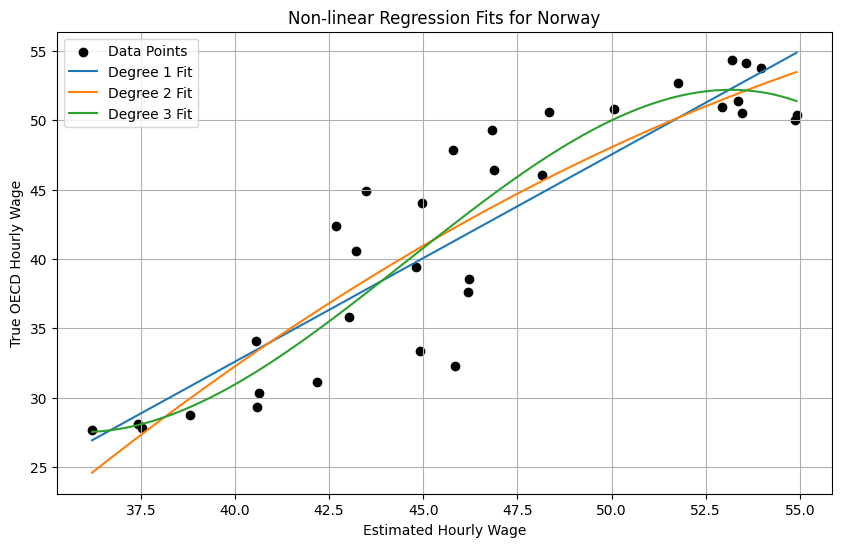

Regression parameters for Norway (rounded to 3 decimals):
degree_1: Intercept = -27.176, Slope (local derivative at mean) = 1.494
degree_2: Intercept = -94.861, Slope (local derivative at mean) = 1.499
degree_3: Intercept = 801.991, Slope (local derivative at mean) = 2.067


In [18]:
# Can be ingored # First code to try to see Norway estimate with non linear regressions, doesn't improve, so need to check with adding a variable

# ---- Configuration ----
# Set a manual adjustment factor (e.g., to adjust for oil revenue anomaly)
adjustment_factor = 0.0  # change this value as needed; set to 0 for no adjustment

# Select the degrees of polynomial to test: 1 = linear, 2 = quadratic, 3 = cubic
degrees = [1, 2, 3]

# ---- Data Preparation ----
# Filter the merged dataframe for Norway, drop missing values, and sort by year
df_norway = df_compare[df_compare["country"] == "Norway"].dropna(subset=["estimated_hourly_wage", "oecd_hourly_wage"]).sort_values("year")

if len(df_norway) < 2:
    print("Not enough data for Norway to run a regression.")
else:
    # Prepare predictor and response variables.
    # Apply a manual adjustment (if any) to estimated wage:
    X = (df_norway[["estimated_hourly_wage"]].values - adjustment_factor)
    y = df_norway["oecd_hourly_wage"].values

    # Create a range for plotting predictions. We'll use a fine grid between min and max estimated wage.
    X_plot = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

    # We'll store results for printing later.
    results = {}

    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color="black", label="Data Points")

    # We'll compute the mean estimated wage (after adjustment) to use for derivative calculation.
    X_mean = np.mean(X)

    for deg in degrees:
        # Create a pipeline with PolynomialFeatures and LinearRegression
        model = Pipeline([
            ('poly', PolynomialFeatures(degree=deg, include_bias=False)),
            ('lin_reg', LinearRegression())
        ])
        model.fit(X, y)
        y_pred = model.predict(X_plot)

        # For degree=1, we can easily get intercept and slope.
        if deg == 1:
            intercept = model.named_steps["lin_reg"].intercept_
            slope = model.named_steps["lin_reg"].coef_[0]
        else:
            # For non-linear models, we compute the derivative at the mean of X.
            # The polynomial model is: f(x) = c0*x + c1*x^2 + ... + c_{deg-1} * x^deg + intercept.
            # Its derivative is: f'(x) = c0 + 2*c1*x + ... + deg*c_{deg-1} * x^(deg-1)
            lin_coefs = model.named_steps["lin_reg"].coef_
            intercept = model.named_steps["lin_reg"].intercept_
            derivative = lin_coefs[0]
            for d in range(2, deg+1):
                derivative += d * lin_coefs[d-1] * (X_mean ** (d-1))
            slope = derivative

        # Store rounded results (3 decimals)
        results[f"degree_{deg}"] = {"intercept": round(intercept, 3),
                                    "slope (deriv at mean)": round(slope, 3)}

        # Plot the fitted curve
        plt.plot(X_plot + adjustment_factor, y_pred, label=f"Degree {deg} Fit")

    plt.xlabel("Estimated Hourly Wage" + (" (adjusted)" if adjustment_factor else ""))
    plt.ylabel("True OECD Hourly Wage")
    plt.title("Non-linear Regression Fits for Norway")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the regression parameters for each model
    print("Regression parameters for Norway (rounded to 3 decimals):")
    for key, params in results.items():
        print(f"{key}: Intercept = {params['intercept']}, Slope (local derivative at mean) = {params['slope (deriv at mean)']}")


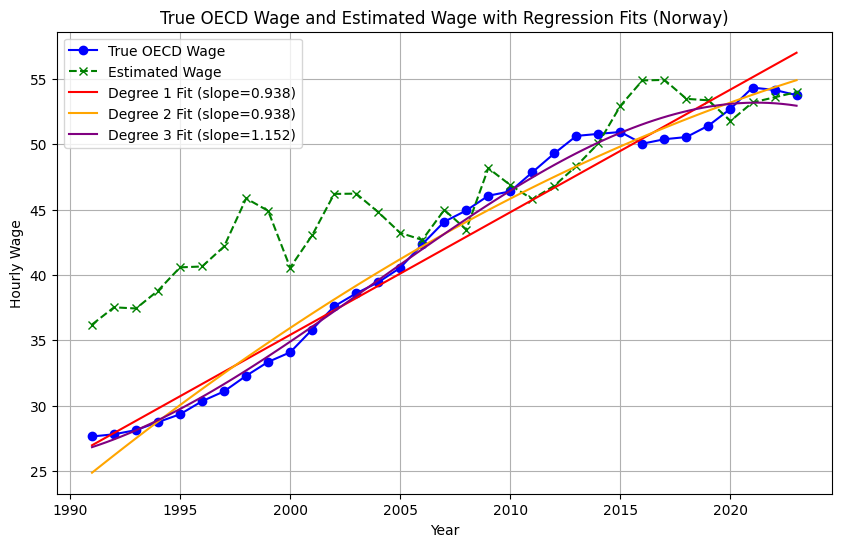

Regression parameters for Norway (using year as predictor):
degree_1: Intercept = -1840.908, Slope (local derivative at mean) = 0.938
degree_2: Intercept = -52972.565, Slope (local derivative at mean) = 0.938
degree_3: Intercept = 10570007.525, Slope (local derivative at mean) = 1.152


In [19]:
# IGNORE AS WELL # Second code with the plots

# Filter the merged dataframe for Norway, drop missing values, and sort by year
df_norway = df_compare[df_compare["country"] == "Norway"].dropna(
    subset=["estimated_hourly_wage", "oecd_hourly_wage"]
).sort_values("year")

if len(df_norway) < 2:
    print("Not enough data for Norway to run a regression.")
else:
    # Use "year" as the predictor
    X_year = df_norway[["year"]].values
    # True OECD hourly wage (as reported) and our estimated wage
    y_true = df_norway["oecd_hourly_wage"].values
    y_est = df_norway["estimated_hourly_wage"].values

    # Create a grid for plotting regression predictions
    X_plot = np.linspace(df_norway["year"].min(), df_norway["year"].max(), 100).reshape(-1,1)

    # Start plotting: plot both the true OECD wage and the estimated wage over time
    plt.figure(figsize=(10,6))
    plt.plot(df_norway["year"], y_true, color="blue", marker="o", linestyle="-", label="True OECD Wage")
    plt.plot(df_norway["year"], y_est, color="green", marker="x", linestyle="--", label="Estimated Wage")

    # Dictionary to store regression parameters for each model
    results = {}
    degrees = [1, 2, 3]
    colors = ["red", "orange", "purple"]

    for i, deg in enumerate(degrees):
        # Create a pipeline to fit a polynomial regression model of specified degree
        model = Pipeline([
            ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
            ("lin_reg", LinearRegression())
        ])
        model.fit(X_year, y_true)
        y_pred = model.predict(X_plot)

        # For linear (degree 1), we can directly obtain slope and intercept
        if deg == 1:
            intercept = model.named_steps["lin_reg"].intercept_
            slope = model.named_steps["lin_reg"].coef_[0]
        else:
            # For polynomial regression, approximate the local slope by computing the derivative at the mean year.
            coefs = model.named_steps["lin_reg"].coef_
            intercept = model.named_steps["lin_reg"].intercept_
            X_mean = np.mean(X_year)
            # The polynomial model: y = c0*x + c1*x^2 + ... + c_{deg-1}*x^deg + intercept
            # Its derivative is: f'(x) = c0 + 2*c1*x + ... + deg*c_{deg-1}*x^(deg-1)
            slope = sum((d+1) * coefs[d] * (X_mean ** d) for d in range(len(coefs)))

        # Round the regression parameters to 3 decimals
        intercept = round(intercept, 3)
        slope = round(slope, 3)
        results[f"degree_{deg}"] = {"intercept": intercept, "slope (local derivative at mean)": slope}

        # Plot the fitted regression curve
        plt.plot(X_plot, y_pred, color=colors[i], linestyle="-", label=f"Degree {deg} Fit (slope={slope})")

    plt.xlabel("Year")
    plt.ylabel("Hourly Wage")
    plt.title("True OECD Wage and Estimated Wage with Regression Fits (Norway)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the regression parameters for each model
    print("Regression parameters for Norway (using year as predictor):")
    for key, params in results.items():
        print(f"{key}: Intercept = {params['intercept']}, Slope (local derivative at mean) = {params['slope (local derivative at mean)']}")


CSV data saved to norway_data.csv
Plot saved to Project_Wage_Convergence/Norway_Wage_Oil_comparison.pdf


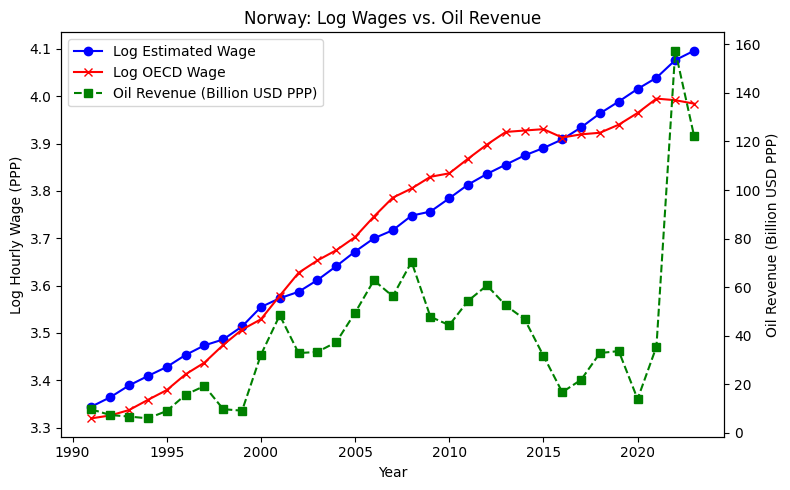

In [25]:
# Comparing norwegian oil, estimate wages and true wages

# 1. Load your existing wage data
df_est = pd.read_csv(os.path.expanduser('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/Countries_Wages_Estimates_Finals_GOOD.csv'))
df_oecd = pd.read_csv(os.path.expanduser('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/OECD_wages_merged.csv'))
df_oecd.rename(columns={"Country": "country", "Wages": "oecd_annual_wage", "Year": "year"}, inplace=True)
df_oecd["year"] = pd.to_numeric(df_oecd["year"], errors="coerce")

df_compare = pd.merge(
    df_est,
    df_oecd[["country", "year", "oecd_annual_wage"]],
    on=["country", "year"],
    how="inner"
)

df_compare["oecd_hourly_wage"] = df_compare["oecd_annual_wage"] / df_compare["whours"]
df_compare["diff"] = df_compare["estimated_hourly_wage"] - df_compare["oecd_hourly_wage"]
df_compare["ratio"] = df_compare["estimated_hourly_wage"] / df_compare["oecd_hourly_wage"]

df_compare["log_estimated_hourly_wage"] = np.log(df_compare["estimated_hourly_wage"])
df_compare["log_oecd_hourly_wage"] = np.log(df_compare["oecd_hourly_wage"])

# 2. Load Norwegian oil revenue from Excel
df_oil = pd.read_excel(
    os.path.expanduser('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/Norwegian_Oil_revenue.xlsx'),
    sheet_name='Noe'
)
df_oil.rename(
    columns={
        "Year": "year",
        "NCF converted in PPP": "oil_revenue_billion_usd"
    },
    inplace=True
)

# 3. Merge with df_compare but only for Norway
df_norway = df_compare[df_compare["country"] == "Norway"].copy()
df_norway_merged = pd.merge(df_norway, df_oil[["year", "oil_revenue_billion_usd"]], on="year", how="inner")

# ---------------------------------------------------
# 4. Save the required data as a CSV file for LaTeX
# ---------------------------------------------------
# Select only the columns needed for your LaTeX plot
df_norway_export = df_norway_merged[["year", "log_estimated_hourly_wage", "log_oecd_hourly_wage", "oil_revenue_billion_usd"]]
output_csv = os.path.expanduser('norway_data.csv')
df_norway_export.to_csv(output_csv, index=False)
print(f"CSV data saved to {output_csv}")

# ---------------------------------------------------
# 5. Plot a Dual-Axis Chart for Norway: Log Wages vs. Oil Revenue
# ---------------------------------------------------
fig, ax1 = plt.subplots(figsize=(8, 5))

# Primary y-axis: Log wages
ax1.plot(
    df_norway_merged["year"],
    df_norway_merged["log_estimated_hourly_wage"],
    marker='o', color='blue', label='Log Estimated Wage'
)
ax1.plot(
    df_norway_merged["year"],
    df_norway_merged["log_oecd_hourly_wage"],
    marker='x', color='red', label='Log OECD Wage'
)
ax1.set_xlabel("Year")
ax1.set_ylabel("Log Hourly Wage (PPP)")
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_title("Norway: Log Wages vs. Oil Revenue")

# Secondary y-axis: Oil revenue
ax2 = ax1.twinx()
ax2.plot(
    df_norway_merged["year"],
    df_norway_merged["oil_revenue_billion_usd"],
    marker='s', color='green', linestyle='--', label='Oil Revenue (Billion USD PPP)'
)
ax2.set_ylabel("Oil Revenue (Billion USD PPP)")
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.tight_layout()

# 6. Save the plot to a PDF file (for reference) and display it
output_dir = os.path.expanduser('Project_Wage_Convergence')
output_file = os.path.join(output_dir, 'Norway_Wage_Oil_comparison.pdf')
os.makedirs(output_dir, exist_ok=True)
plt.savefig(output_file)
print(f"Plot saved to {output_file}")

plt.show()

Regression Model: log_oecd_hourly_wage = intercept + a*year + b*log_est + c*oil_revenue
Intercept: -0.000
year coefficient: 0.000
log_estimated_hourly_wage coefficient: 1.000
oil_revenue_billion_usd coefficient: -0.000
Plot saved to Project_Wage_Convergence/Norway_Wage_oil_adjusted_comparison.pdf


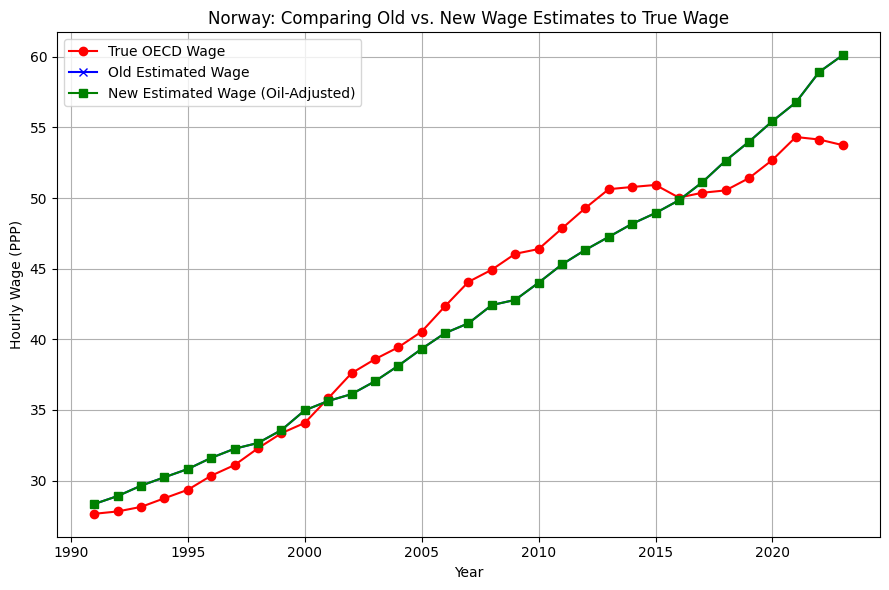

Old Estimate MSE: 5.482
New Oil-Adjusted Estimate MSE: 5.482
The new oil-adjusted estimate does not improve MSE compared to the old estimate.
                            OLS Regression Results                            
Dep. Variable:       oecd_hourly_wage   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     623.3
Date:                Wed, 07 May 2025   Prob (F-statistic):           4.31e-22
Time:                        17:00:59   Log-Likelihood:                 52.174
No. Observations:                  33   AIC:                            -100.3
Df Residuals:                      31   BIC:                            -97.36
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|   

In [27]:
# Adjusting Norwegian wages estimate

# 1. We assume df_norway_merged is already defined and contains:
#    [year, estimated_hourly_wage, oecd_hourly_wage, log_estimated_hourly_wage, log_oecd_hourly_wage, oil_revenue_billion_usd]

# Drop any rows that lack data for these key variables
df_norway_model = df_norway_merged.dropna(subset=[
    "year", "log_estimated_hourly_wage", "oil_revenue_billion_usd", "log_oecd_hourly_wage"
]).copy()

if len(df_norway_model) < 5:
    print("Not enough data points for regression.")
else:
    # 2. Prepare the regression inputs: predict log_oecd_hourly_wage using year, log_estimated_hourly_wage, and oil_revenue_billion_usd.
    X = df_norway_model[["year", "log_estimated_hourly_wage", "oil_revenue_billion_usd"]]
    y = df_norway_model["log_oecd_hourly_wage"]

    # Fit the linear regression
    model = LinearRegression().fit(X, y)

    # Extract coefficients and print them
    intercept = model.intercept_
    coefs = model.coef_
    print("Regression Model: log_oecd_hourly_wage = intercept + a*year + b*log_est + c*oil_revenue")
    print(f"Intercept: {intercept:.3f}")
    print(f"year coefficient: {coefs[0]:.3f}")
    print(f"log_estimated_hourly_wage coefficient: {coefs[1]:.3f}")
    print(f"oil_revenue_billion_usd coefficient: {coefs[2]:.3f}")

    # 3. Generate new predictions (on the log scale) and exponentiate to get wage in levels.
    df_norway_model["log_estimated_wage_with_oil"] = model.predict(X)
    df_norway_model["estimated_wage_with_oil"] = np.exp(df_norway_model["log_estimated_wage_with_oil"])

    # 4. Plot the comparison:
    plt.figure(figsize=(9,6))

    # Plot the true OECD wage (red)
    plt.plot(
        df_norway_model["year"],
        df_norway_model["oecd_hourly_wage"],
        marker='o', color='red', label='True OECD Wage'
    )

    # Plot the old estimated wage (blue)
    plt.plot(
        df_norway_model["year"],
        df_norway_model["estimated_hourly_wage"],
        marker='x', color='blue', label='Old Estimated Wage'
    )

    # Plot the new oil-adjusted wage (green)
    plt.plot(
        df_norway_model["year"],
        df_norway_model["estimated_wage_with_oil"],
        marker='s', color='green', label='New Estimated Wage (Oil-Adjusted)'
    )

    plt.title("Norway: Comparing Old vs. New Wage Estimates to True Wage")
    plt.xlabel("Year")
    plt.ylabel("Hourly Wage (PPP)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # 5. Save the plot to a PDF file for LaTeX inclusion
    output_dir = os.path.expanduser('Project_Wage_Convergence')
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, 'Norway_Wage_oil_adjusted_comparison.pdf')
    plt.savefig(output_file)
    print(f"Plot saved to {output_file}")

    # 6. Show the plot
    plt.show()

    # 7. (Optional) Evaluate the fit via MSE
    mse_old = np.mean((df_norway_model["estimated_hourly_wage"] - df_norway_model["oecd_hourly_wage"])**2)
    mse_new = np.mean((df_norway_model["estimated_wage_with_oil"] - df_norway_model["oecd_hourly_wage"])**2)
    print(f"Old Estimate MSE: {mse_old:.3f}")
    print(f"New Oil-Adjusted Estimate MSE: {mse_new:.3f}")

    if mse_new < mse_old:
        print("The new oil-adjusted estimate has a lower MSE, indicating a better fit.")
    else:
        print("The new oil-adjusted estimate does not improve MSE compared to the old estimate.")


# make sure df_norway exists and has oecd_hourly_wage & estimated_hourly_wage
log_oecd = np.log(df_norway["oecd_hourly_wage"])
log_est = np.log(df_norway["estimated_hourly_wage"])

# add_constant will now work
X = sm.add_constant(log_est)
model = sm.OLS(log_oecd, X).fit()

print(model.summary())
print("MSE on log-scale:", model.mse_resid)

In [29]:
# Update our wages list with the new value for Norway

# 1. Load the existing final wages file (wages_final)
df_final = pd.read_csv('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/Countries_Wages_Estimates_Finals_GOOD.csv')

# 2. Assume df_norway_model is already defined from previous analysis,
#    and it contains the new oil-adjusted wage estimates for Norway.
#    We extract just the "year" and "estimated_wage_with_oil" columns.
df_norway_new = df_norway_model[['year', 'estimated_wage_with_oil']]

# 3. Update df_final for rows where country == "Norway"
#    We perform a merge on "year" for the Norway rows.
df_norway_final = df_final[df_final["country"] == "Norway"].merge(
    df_norway_new, on="year", how="left"
)

# 4. Replace the old estimated_hourly_wage with the new oil-adjusted wage for Norway
df_final.loc[df_final["country"] == "Norway", "estimated_hourly_wage"] = df_norway_final["estimated_wage_with_oil"].values

# 5. Save the updated file
output_path = 'Project_Wage_Convergence/Countries_Wages_Estimates_Finals_GOOD.csv'
df_final.to_csv(output_path, index=False)
print(f"Updated wages file saved to {output_path}")


Updated wages file saved to Project_Wage_Convergence/Countries_Wages_Estimates_Finals_GOOD.csv


In [30]:
# create a plot for OECD benchmark vs. our estimate with fancier colors

# 1. Load our estimated wages (df_final) and OECD raw data
df_final = pd.read_csv(os.path.expanduser('Project_Wage_Convergence/Countries_Wages_Estimates_Finals_GOOD.csv'))
df_oecd  = pd.read_csv(os.path.expanduser('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/OECD_wages_merged.csv'))

# 2. Rename OECD columns to match df_final keys
df_oecd.rename(columns={
    'Country': 'country',
    'Year':    'year',
    'Wages':   'oecd_annual_wage'
}, inplace=True)
df_oecd['year'] = pd.to_numeric(df_oecd['year'], errors='coerce')

# 3. Merge on country + year
df_compare = pd.merge(
    df_final,
    df_oecd[['country','year','oecd_annual_wage']],
    on=['country','year'],
    how='inner'
)

# 4. Compute OECD hourly wage
df_compare['oecd_hourly_wage'] = df_compare['oecd_annual_wage'] / df_compare['whours']

# 5. Compute yearly averages
avg_wages = df_compare.groupby('year').agg(
    avg_estimated = ('estimated_hourly_wage', 'mean'),
    avg_oecd      = ('oecd_hourly_wage',     'mean')
).reset_index()

# 6. Plot raw-hourly comparison with custom colors
plt.figure(figsize=(10,6))
# use a colormap for two lines
colors = plt.get_cmap('viridis')(np.linspace(0.2, 0.8, 2))
plt.plot(avg_wages['year'], avg_wages['avg_estimated'], marker='o', color=colors[0], linewidth=2, label='Estimated')
plt.plot(avg_wages['year'], avg_wages['avg_oecd'],      marker='x', color=colors[1], linewidth=2, label='OECD')
plt.xlabel('Year')
plt.ylabel('Hourly Wage (PPP)')
plt.title('Average Hourly Wage: Estimate vs OECD')
plt.legend(frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
out_raw = os.path.expanduser('Avg_Hourly_Comparison_GOOD.pdf')
with PdfPages(out_raw) as pdf:
    pdf.savefig()
    plt.close()
print(f"Saved raw comparison to {out_raw}")

# 7. Compute & plot log-transformed averages
avg_wages_log = df_compare.groupby('year').agg(
    log_avg_est = ('estimated_hourly_wage', lambda x: np.log(x).mean()),
    log_avg_oecd= ('oecd_hourly_wage',      lambda x: np.log(x).mean())
).reset_index()

plt.figure(figsize=(10,6))
# use a different colormap
colors2 = plt.get_cmap('plasma')(np.linspace(0.2, 0.8, 2))
plt.plot(avg_wages_log['year'], avg_wages_log['log_avg_est'],  marker='o', color=colors2[0], linewidth=2, label='Log Estimated')
plt.plot(avg_wages_log['year'], avg_wages_log['log_avg_oecd'], marker='x', color=colors2[1], linewidth=2, label='Log OECD')
plt.xlabel('Year')
plt.ylabel('Log Hourly Wage')
plt.title('Log Average Hourly Wage: Estimate vs OECD')
plt.legend(frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
out_log = os.path.expanduser('Log_Hourly_Comparison_GOOD.pdf')
with PdfPages(out_log) as pdf:
    pdf.savefig()
    plt.close()
print(f"Saved log comparison to {out_log}")

Saved raw comparison to Avg_Hourly_Comparison_GOOD.pdf
Saved log comparison to Log_Hourly_Comparison_GOOD.pdf


## Costa Rica (F)

## Colombia (A)

## Greece (A)

## Mexico (F)

## Luxembourg